In [1]:
import logging
logging.basicConfig(level=logging.WARNING)
import lch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

This team consists of: [<lch.model.Model object at 0x7fa0611d1940>, <lch.model.Model object at 0x7fa0611d1970>, <lch.model.Model object at 0x7fa0611d19a0>]
This team consists of: [<lch.model.Model object at 0x7fa0611d1b80>, <lch.model.Model object at 0x7fa0611d1bb0>, <lch.model.Model object at 0x7fa0611d1be0>]


In [2]:
size_x, size_y = (24,16)

def empty(x,y):
    return 1,1

def one_building(x,y):
    # blocks los and movement
    xmin, xmax = 9,15
    ymin, ymax = 6,10
    move, los = 1, 1
    if xmin <= x and x <= xmax and ymin <= y and y <= ymax:
        move = 10000
        los = 10000
    return move, los

def pond(x,y):
    # can see through, but prob not walk
    los = 1
    cx, cy = size_x/2, size_y/2
    radius = 5
    move = 1
    if (x-cx)**2 + (y-cy)**2 < radius**2:
        move += (radius ** 2 - (x-cx)**2 - (y-cy)**2)**0.5
    return move, los

class Forest(object):
    """
    Generates a bunch of trees in random locations. A bit more overhead
    """
    num_trees = np.random.poisson(5)
    center = (size_x//2, size_y//2)
    size_x, size_y = (size_x//4, size_y//4)
    possible_spots = list(itertools.product(range(center[0]-size_x, center[0]+size_x),range(center[1]-size_y, center[1]+size_y)))
    selected_spots = np.random.choice(possible_spots, size=num_trees, replace=False)
    
    @classmethod
    def generate(cls, x, y):
        if (x,y) in cls.selected_spots:
            return -1, -1
        return 0, 0

bf_empty = lch.Battlefield(size_x, size_y, empty)
bf_one_build = lch.Battlefield(size_x, size_y, one_building)
bf_pond = lch.Battlefield(size_x, size_y, pond)
bf_forest = lch.Battlefield(size_x, size_y, Forest.generate)

Direction: -1,1,2.521
Evaluating (15, 1): 0.581,0.814
Evaluating (14, 1): 1.162,0.232
Evaluating (14, 2): 0.349,1.046
Evaluating (13, 2): 0.930,0.465
Evaluating (13, 3): 0.116,1.279
Evaluating (12, 3): 0.697,0.697
Evaluating (11, 4): 0.465,0.930
Evaluating (10, 4): 1.046,0.349
Evaluating (10, 5): 0.232,1.162
Evaluating (9, 5): 0.814,0.581
Evaluating (9, 6): 0.000,1.395
Evaluating (8, 6): 0.581,0.814
Evaluating (7, 6): 1.162,0.232
Evaluating (7, 7): 0.349,1.046
Evaluating (6, 7): 0.930,0.465
Evaluating (6, 8): 0.116,1.279
Evaluating (5, 8): 0.697,0.697
Evaluating (4, 9): 0.465,0.930
Evaluating (3, 9): 1.046,0.349
Evaluating (3, 10): 0.232,1.162
Evaluating (2, 10): 0.814,0.581
Evaluating (2, 11): 0.000,1.395


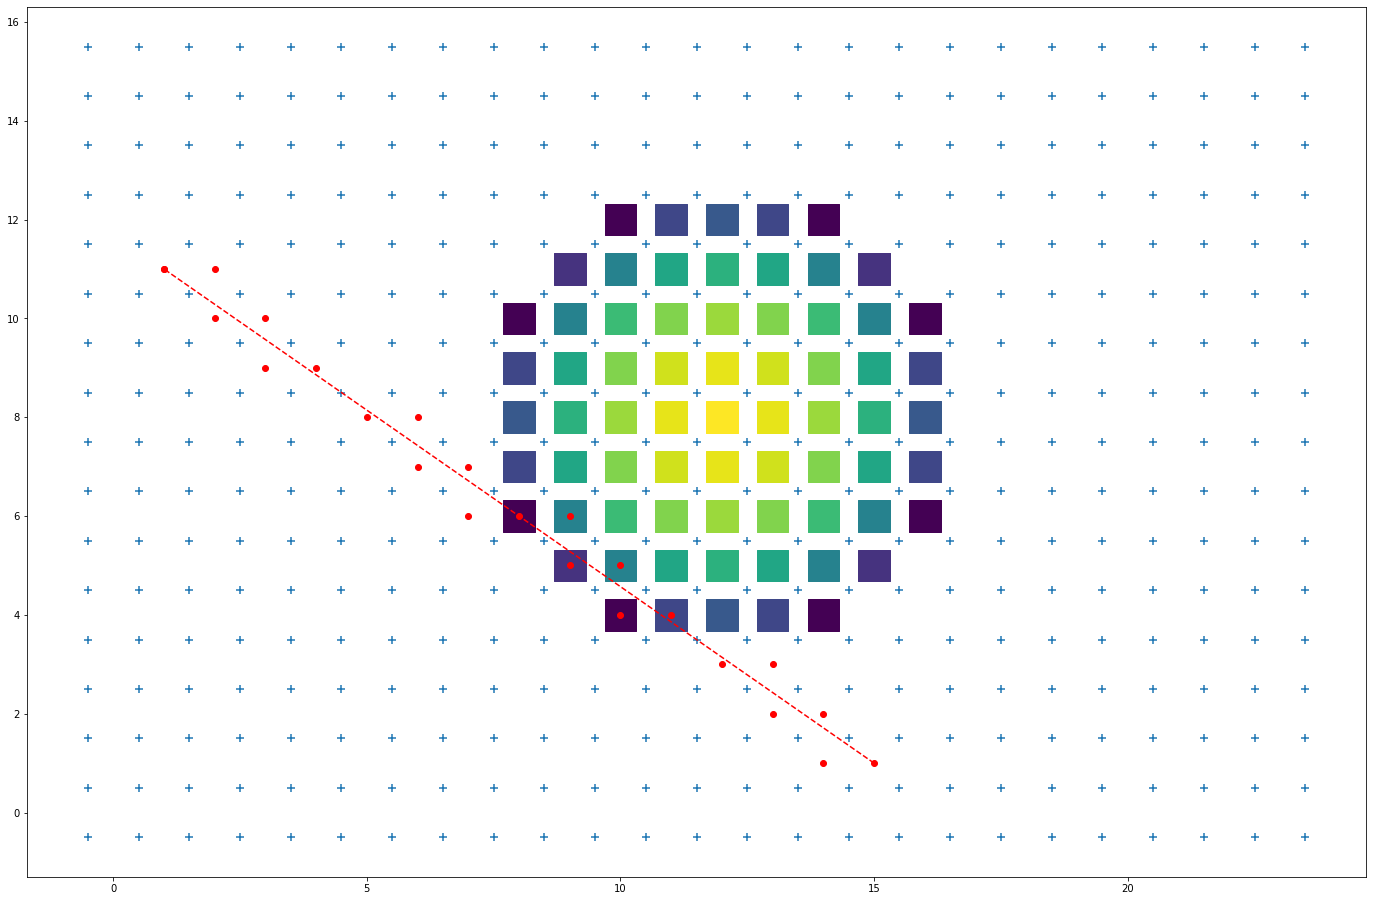

In [5]:
def plot_bf(ax, bf, trait='movement'):
    size_x, size_y = bf.size
    xx,yy = np.meshgrid(np.arange(size_x+1)-0.5, np.arange(size_y+1)-0.5)
    ax.scatter(xx,yy, marker='+', s=50)
    terrain = []
    for (x,y), sq in bf.cache.items():
        if trait == 'movement' and sq.move_scale > 1:
            terrain.append((x,y,sq.move_scale))
        elif trait == 'los' and sq.los_blocking > 1:
            terrain.append((x,y,sq.los_blocking))
    terrain = np.array(terrain, dtype=[('x', np.int),('y', np.int),('color', np.float)])
    ax.scatter(terrain['x'], terrain['y'], c=terrain['color'], marker='s', s=1000)
    return

def plot_astar(ax, bf, start, end):
    path, _ = bf.astar_path(start, end)
    ax.scatter([l[0] for l in path], [l[1] for l in path], c='r')

def plot_los(ax, bf, start, end):
    path = bf.los_range(start, end)
    ax.plot([start[0], end[0]], [start[1], end[1]], ls='--', c='r')
    ax.scatter([l[0] for l in path], [l[1] for l in path], c='r')

fig, ax = plt.subplots(figsize=(size_x,size_y))
plot_bf(ax, bf_pond)
plot_los(ax, bf_pond, (15,1), (1,11))
plt.show()

In [20]:
4e6/(0.0106 * 7.753e9)

0.04867257713995069

In [30]:
import itertools
class PriorityQueue(object):
    """
    Class that implements a priority queue to support pathfinding
    """
    def __init__(self, x, p=1):
        """
        Constructor
        :param x: the first item for the queue
        :param p: float, the priority, default 0
        """
        self.q = [(x,p)]

    def put(self, x, p):
        """
        Puts a new item into the queue so that it's still sorted. The queue
        is guaranteed to have stuff in it so we don't check first
        :param x: the item
        :param p: float, the priority
        :returns: None
        """
        print(f'Inserting {p:.2f}, current list:')
        for i,(_,_p) in enumerate(self.q):
            print(f"{i}, {_p:.2f}")
        if len(self.q) == 1:
            if self.q[0][1] >= p:
                self.q.insert(0, (x,p))
            else:
                self.q.append((x,p))
        else:
            idx = len(self.q)//2
            print(f'Starting at {idx}')
            for i in itertools.count(2):
                lesser = self.q[idx-1][1] if idx >= 1 else -1
                greater = self.q[idx][1] if idx < len(self.q) else 999999999
                delta = max(1, len(self.q)>>i)
                if lesser <= p <= greater:
                    print(f'Inserting {p:.1f} before {idx} ({lesser:.1f},{greater:.1f})')
                    self.q.insert(idx, (x,p))
                    return
                elif p > greater:
                    print(f'Going {idx} -> {idx+delta}')
                    idx += delta
                elif p < lesser:
                    print(f'Going {idx} -> {idx-delta}')
                    idx -= delta
                if i >= 10:
                    break

    def get(self):
        """
        Returns the item with the lowest score (aka the first item). Does not return
        the priority
        """
        return self.q.pop(0)[0]

    def empty(self):
        """
        Returns whether or not the queue is currently empty
        """
        return len(self.q) == 0

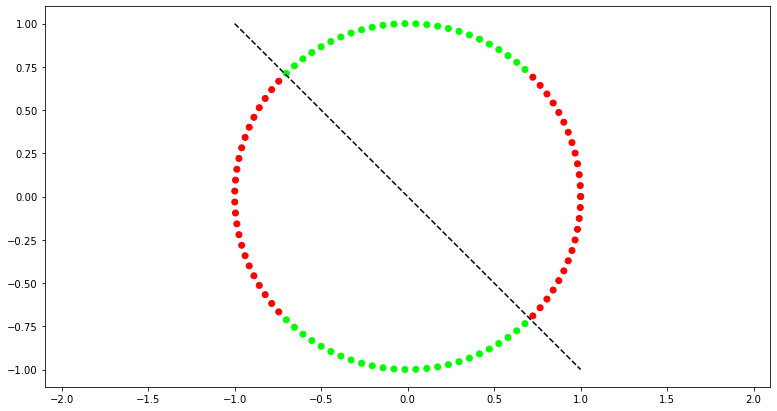

In [11]:
def f(angle):
    scale = 1/np.sqrt(2)
    c, s = np.cos(angle)*scale, np.sin(angle)*scale
    dx, dy = round(c), round(s)
    return abs(dx), abs(dy), 0

fig = plt.figure(figsize=(13,7))
theta = np.linspace(0,2*np.pi,100)
plt.scatter(np.cos(theta), np.sin(theta), c=list(map(f, theta)))
plt.plot([-1,-1],[1,1], ls='--',c='k')
plt.plot([-1,1],[1,-1], ls='--',c='k')

plt.axis('equal')
plt.show()